In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score


In [2]:
# Download the data
transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_data = datasets.CIFAR100(
    root = 'data', #directory to store the dataset in
    # True for training dataset, False for testing
    train = True,
    download = True,
    transform = transforms
)

testing_data = datasets.CIFAR100(
    root = 'data',
    train = False,
    download = True,
    transform = transforms
)
classes = training_data.classes

# DataLoader pytorch.org/docs/stable/data.html
batch_size = 128
training_dataloader = DataLoader(training_data, batch_size=batch_size)
testing_dataloader = DataLoader(testing_data, batch_size=batch_size)

# For CIFAR-100 we expect 60k total images
# 100 classes with 600 images each
# that's 50k training and 10k testing (500 training/100 testing per class)
print(f'training: {batch_size*len(training_dataloader)}, testing: {batch_size*len(testing_dataloader)}')

Files already downloaded and verified
Files already downloaded and verified
training: 50048, testing: 10112


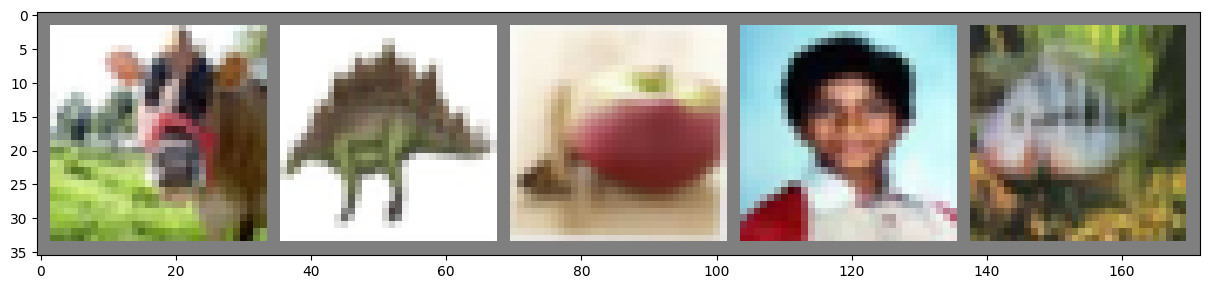

Ordered Labels:
cattle dinosaur apple boy   aquarium_fish


In [3]:
# Peek at the data
# manually verify labels are correct:
# https://huggingface.co/datasets/cifar100
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.figure(figsize=(15, 15))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(training_dataloader)
images, labels = next(dataiter)
images = images[:5]
labels = labels[:5]

imshow(make_grid(images))
print('Ordered Labels:')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

128
shape of X [batch, channel, height, width]: torch.Size([128, 3, 32, 32])
shape of Y: torch.Size([128])


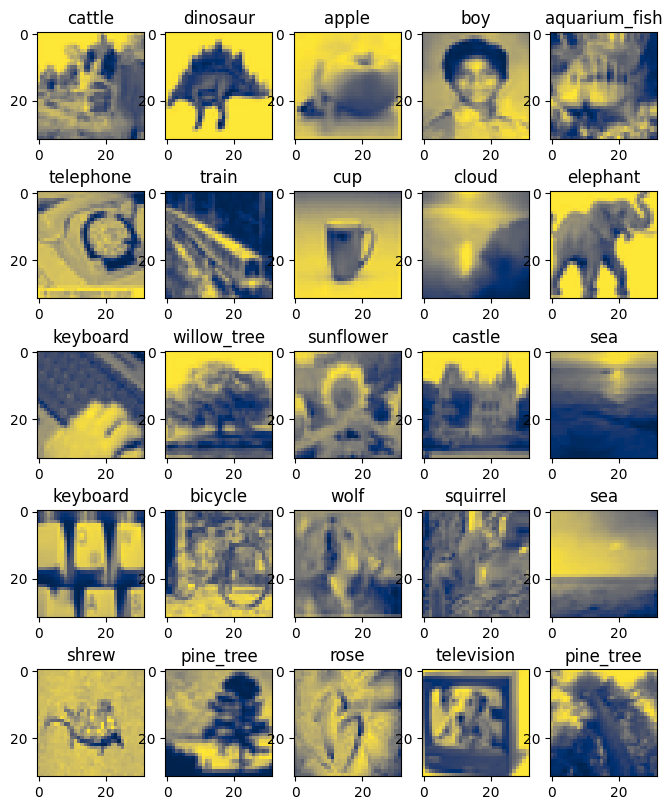

In [4]:
# Another way to visualize the data

# each data is length 2 where data[0] is data and data[1] is fine label
for data in training_dataloader:
  break

# manually verify labels are correct:
# https://huggingface.co/datasets/cifar100
X = data[0]
Y = data[1]

colormap = 'cividis'
print(len(data[1]))
print('shape of X [batch, channel, height, width]:', X.shape)
print('shape of Y:', Y.shape)
plt.figure(figsize=(8,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  # https://matplotlib.org/stable/users/explain/colors/colormaps.html#colormaps
  plt.imshow(X[i,0,:,:], cmap=colormap)
  plt.title(classes[Y[i].item()])

In [5]:
# Define MLP Class
in_features =  32 * 32 * 3 # 32x32 px and 3 channel (RGB)
hidden_layer_1 = 1024
hidden_layer_2 = 512
hidden_layer_3 = 256
out_features = 100 # 100 classes/labels

class MLP(nn.Module):
  # define structure
  def __init__(self):
    super(MLP, self).__init__()
    # flatten image to a column vector
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        # input layer
        nn.Linear(in_features, hidden_layer_1),
        # non-linear activation
        nn.ReLU(),

        # hidden layers
        nn.Linear(hidden_layer_1, hidden_layer_2),
        nn.ReLU(),
        nn.Linear(hidden_layer_2, hidden_layer_2),
        nn.ReLU(),
        nn.Linear(hidden_layer_2, hidden_layer_3),
        nn.ReLU(),

        # output layer
        nn.Linear(hidden_layer_3, out_features)
    )
  # data flow
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)

    return logits

# Steps per training step
- load one batch (batch=step)
- pass the batch through model
- get model output
- compute the cost/loss/error
- backpropagation

In [6]:
# Define Training

def train(dataloader, model, loss_fn, optimizer, device):
  # model has train and evaluation modes
  model.train()
  # step being a training step
  for step, (X, y) in enumerate(dataloader):
    # send to CPU/GPU
    X = X.to(device)
    y = y.to(device)
    # model's prediction
    pred = model(X)
    # get loss
    loss = loss_fn(pred, y)
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # progress check
    if step % 100 == 0:
      print(f'step: {step}, loss: {loss.item()}')

# validation
def test(dataloader, model, loss_fn, device):
  num_steps = len(dataloader)
  model.eval()
  test_loss = 0
  correct = 0
  y_true = []
  y_predicted = []

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      loss = loss_fn(pred, y)
      test_loss += loss.item()
      y_true.extend(y.cpu().numpy())
      y_hat = pred.argmax(1)
      y_predicted.extend(y_hat.cpu().numpy())
      correct_step = (y_hat == y).type(torch.float).sum().item()
      correct += correct_step

  test_loss /= num_steps # average loss
  correct = correct / (num_steps * batch_size)
  f1 = f1_score(y_true, y_predicted, average='macro')

  print()
  print(f'F1 Score: {f1}')
  print(f'Test Accuracy: {correct}')

In [8]:
# get device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')
# create model
model = MLP().to(device)
print(model)
# optimize
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# train model
epochs = 5
for t in tqdm.tqdm(range(epochs)):
  print(f'Epoch\n\n{t}')
  train(training_dataloader, model, loss_fn, optimizer, device)
  test(testing_dataloader, model, loss_fn, device)
print('Done!')

Using cpu
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=100, bias=True)
  )
)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch

0
step: 0, loss: 4.608701229095459
step: 100, loss: 3.977086305618286
step: 200, loss: 3.5706610679626465
step: 300, loss: 3.7058069705963135


 20%|██        | 1/5 [01:02<04:10, 62.62s/it]

F1 Score: 0.12086363490859332
Test Accuracy: 0.14022943037974683
Epoch

1
step: 0, loss: 3.6729702949523926
step: 100, loss: 3.475152015686035
step: 200, loss: 3.318608283996582
step: 300, loss: 3.475581645965576


 40%|████      | 2/5 [01:52<02:46, 55.41s/it]

F1 Score: 0.16337294637029057
Test Accuracy: 0.1842365506329114
Epoch

2
step: 0, loss: 3.371305227279663
step: 100, loss: 3.2370591163635254
step: 200, loss: 3.140549659729004
step: 300, loss: 3.2994003295898438


 60%|██████    | 3/5 [02:47<01:50, 55.00s/it]

F1 Score: 0.17545954099326458
Test Accuracy: 0.19036787974683544
Epoch

3
step: 0, loss: 3.1622519493103027
step: 100, loss: 3.128938674926758
step: 200, loss: 2.920644760131836
step: 300, loss: 3.063849687576294


 80%|████████  | 4/5 [03:41<00:54, 54.53s/it]

F1 Score: 0.19304530147496762
Test Accuracy: 0.20668512658227847
Epoch

4
step: 0, loss: 3.027303457260132
step: 100, loss: 2.8982086181640625
step: 200, loss: 2.6755692958831787
step: 300, loss: 2.9154388904571533


100%|██████████| 5/5 [04:33<00:00, 54.69s/it]

F1 Score: 0.20568181309963277
Test Accuracy: 0.2164754746835443
Done!


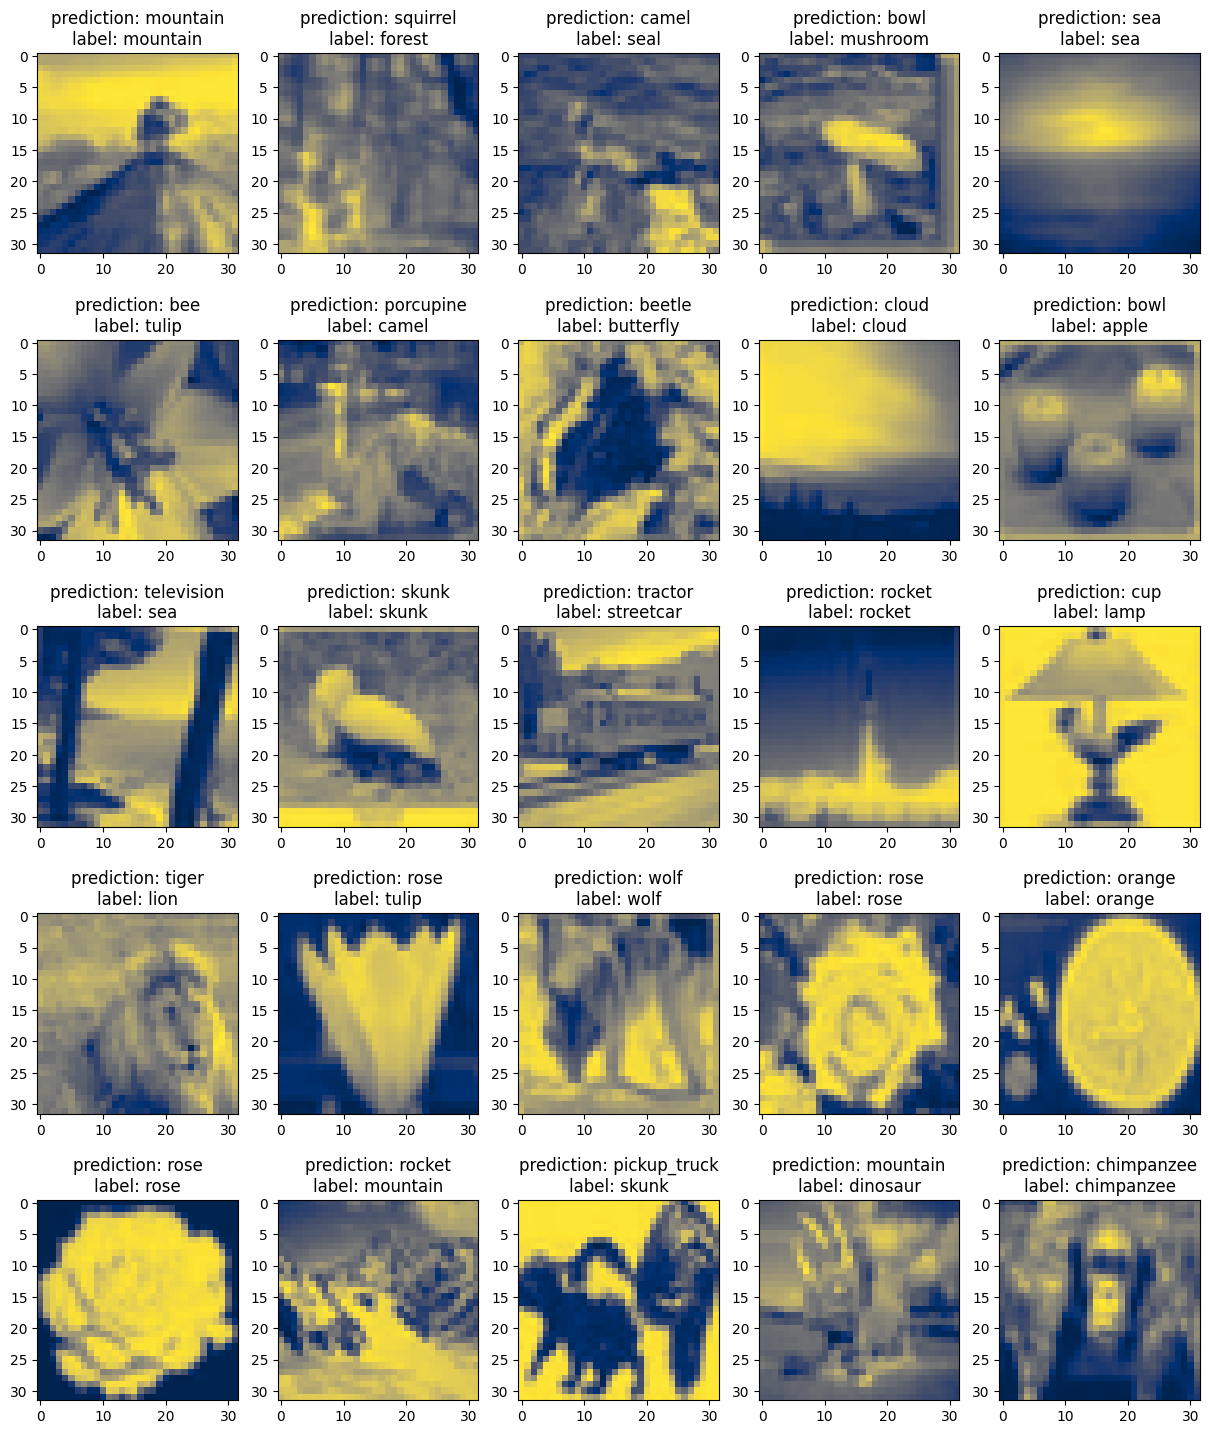

In [10]:
model.eval()
for X, y in testing_dataloader:
  X = X.to(device)
  y = y.to(device)
  with torch.no_grad():
    pred = model(X)
    pred_labels = pred.argmax(1)
  break

plt.figure(figsize=(15,18))
for i in range(25):
  y_hat = pred_labels[i].item()
  y_gt = y[i].item()
  plt.subplot(5,5,i+1)
  plt.imshow(X[i, 0, :, :].cpu().numpy(), cmap=colormap)
  plt.title(f'prediction: {classes[y_hat]}\nlabel: {classes[y_gt]}')